## LOAD LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## LOAD THE DATA

In [3]:
df = pd.read_csv('data/CreditCardFraudFourYears.csv', index_col=0)
df.head(1)

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,765-75-7020,3553287101226916,James,Carlson,M,480 Erin Plain Suite 514,Wilmington,DE,19802,39.7564,...,79fc4fa0f0cd9659311b2d49cfe4a4fc,2019-11-07,03:40:47,1573116047,grocery_pos,339.8,1,fraud_Bradtke PLC,39.817013,-76.261575


## GROUP BY DATE AND COUNT TRANSACTIONS PER DAY

In [4]:
daily_transactions = df.groupby('trans_date').size()
daily_transactions.index = pd.to_datetime(daily_transactions.index)
daily_transactions = daily_transactions.rename('trans_per_day')
daily_transactions.head()
                                               

trans_date
2018-01-01    1016
2018-01-02    1193
2018-01-03    1131
2018-01-04    1170
2018-01-05    1851
Name: trans_per_day, dtype: int64

In [5]:
df = daily_transactions.reset_index()
df.head()

,trans_date,trans_per_day
0,2018-01-01,1016
1,2018-01-02,1193
2,2018-01-03,1131
3,2018-01-04,1170
4,2018-01-05,1851


## PLOT

<Axes: xlabel='trans_date', ylabel='trans_per_day'>

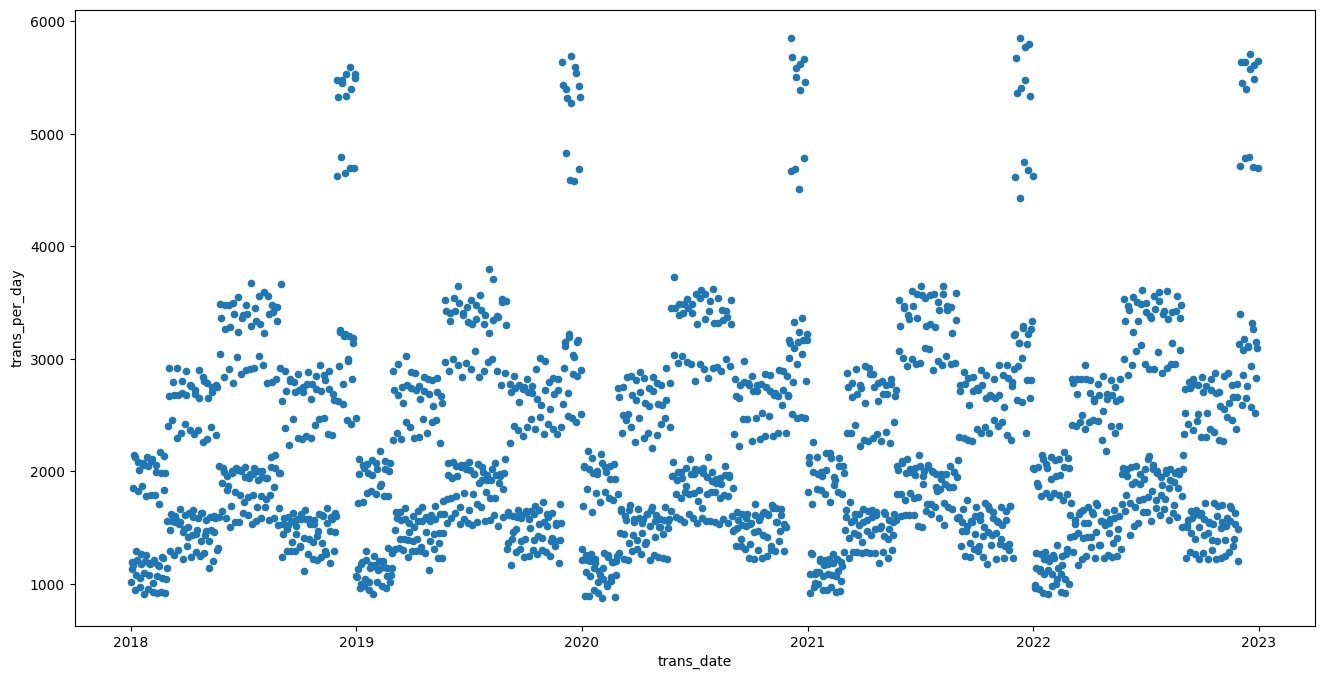

In [6]:
df.plot.scatter(x='trans_date', y='trans_per_day', figsize=(16,8))

In [7]:
df.set_index('trans_date', inplace=True)
df.head()

,trans_per_day
trans_date,
2018-01-01,1016
2018-01-02,1193
2018-01-03,1131
2018-01-04,1170
2018-01-05,1851


## Split Data

In [8]:
df.head()

,trans_per_day
trans_date,
2018-01-01,1016
2018-01-02,1193
2018-01-03,1131
2018-01-04,1170
2018-01-05,1851


In [9]:
len(df)

1826

In [10]:
train = df[['trans_per_day']].iloc[:1826-30]
test = df[['trans_per_day']].iloc[1826-30:]


In [11]:
len(test)

30

## Scale Data

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# FIT ONLY TRAIN DATA, OTHERWISE LEAKS SOME OF THE TEST DATA
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Generate time series data to cover test data

In [114]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 7
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=2)

In [115]:
len(df)-7-7  # Subtract test data and then subtract elements to build first array

1812

In [116]:
df.head()

,trans_per_day
trans_date,
2018-01-01,1016
2018-01-02,1193
2018-01-03,1131
2018-01-04,1170
2018-01-05,1851


In [117]:
len(generator)

895

In [118]:
generator[0]

(array([[[0.02771641],
         [0.06326572],
         [0.05081342],
         [0.05864631],
         [0.19542077],
         [0.25527214],
         [0.25165696]],
 
        [[0.06326572],
         [0.05081342],
         [0.05864631],
         [0.19542077],
         [0.25527214],
         [0.25165696],
         [0.01285399]]]),
 array([[0.01285399],
        [0.03996787]]))

In [119]:
generator[0][0].shape

(2, 7, 1)

In [120]:
generator[0][1].shape

(2, 1)

In [121]:
n_features=1

# Create the Model

In [122]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 100)               40800     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [144]:
model.fit(generator,epochs=30)


Epoch 1/30
895/895 [==============================] - 96s 107ms/step - loss: 0.0020
Epoch 2/30
895/895 [==============================] - 91s 102ms/step - loss: 0.0019
Epoch 3/30
895/895 [==============================] - 87s 97ms/step - loss: 0.0019
Epoch 4/30
895/895 [==============================] - 86s 96ms/step - loss: 0.0020
Epoch 5/30
895/895 [==============================] - 82s 92ms/step - loss: 0.0019
Epoch 6/30
895/895 [==============================] - 84s 94ms/step - loss: 0.0020
Epoch 7/30
895/895 [==============================] - 80s 90ms/step - loss: 0.0019
Epoch 8/30
895/895 [==============================] - 83s 92ms/step - loss: 0.0019
Epoch 9/30
895/895 [==============================] - 90s 100ms/step - loss: 0.0020
Epoch 10/30
895/895 [==============================] - 97s 109ms/step - loss: 0.0019
Epoch 11/30
895/895 [==============================] - 87s 97ms/step - loss: 0.0020
Epoch 12/30
895/895 [==============================] - 93s 103ms/step - loss: 0.0

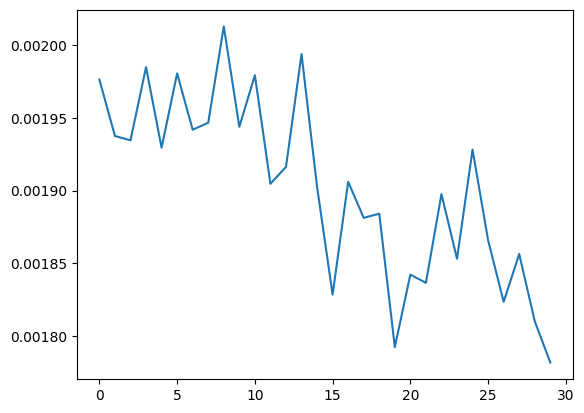

In [145]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaulate the test data

In [146]:
first_eval_batch = scaled_train[-7:]
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))



1/1 [==============================] - 0s 35ms/step


In [147]:
current_batch.shape

(1, 7, 1)

In [148]:
np.append(current_batch[:,1:,:],[[[7]]],axis=1)

array([[[0.38200442],
        [0.35830488],
        [0.06587668],
        [0.12191203],
        [0.45370556],
        [0.50612573],
        [7.        ]]])

In [149]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
# go beyond len(test) to go into the unknown future (no way to measure success except wait!)
for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 27ms/step


## Inverse predictions and compare

In [150]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

In [151]:
test.head()

,trans_per_day,Predictions
trans_date,,
2022-12-02,4719,4289.576552
2022-12-03,5638,4866.216388
2022-12-04,5455,4694.503493
2022-12-05,2591,2988.418297
2022-12-06,2853,2826.950845


<Axes: xlabel='trans_date'>

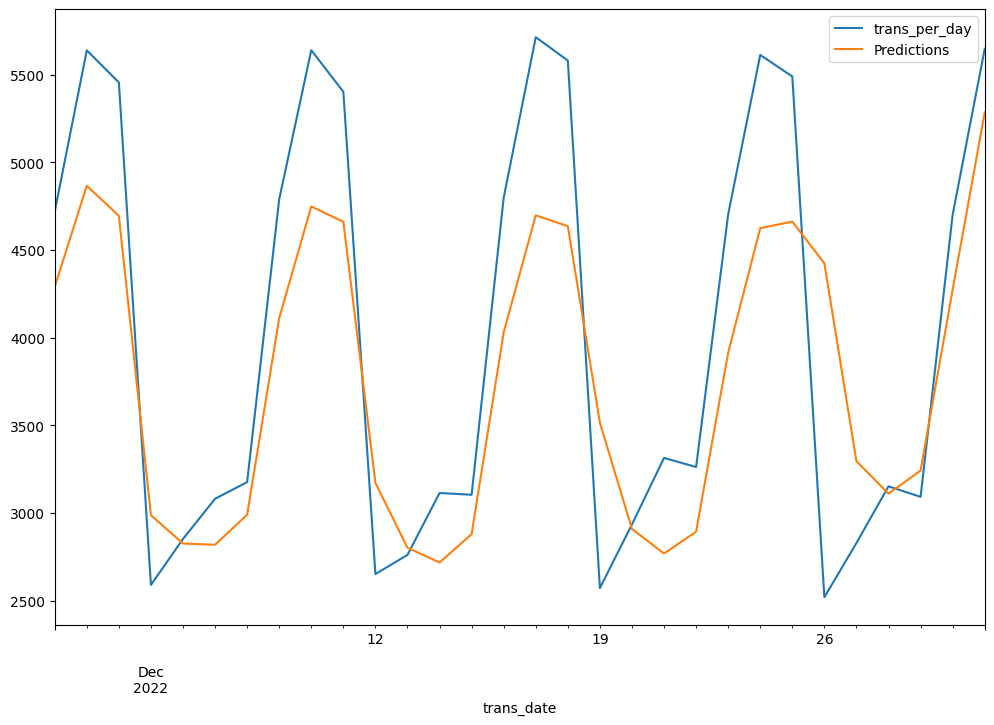

In [152]:
test.plot(figsize=(12,8))

In [153]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['trans_per_day'], test['Predictions']))
mse=mean_squared_error(test['trans_per_day'], test['Predictions'])
print(rmse)
print(mse)

687.7054903472803
472938.84145379317
